In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor,Compose, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
import torchvision.transforms as T
from torch.optim.adam import Adam
from torchvision.models.vgg import vgg16
from torch.utils.data.dataloader import DataLoader
import tqdm

In [14]:
transforms=Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),

    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261)),
    T.ToPILImage()
])

training_data=CIFAR10(
    root="./data/",
    train=True,
    download=True,
    transform=transforms
)

test_data=CIFAR10(
    root="./data/",
    train=False,
    download=True,
    transform=transforms
)


100%|██████████| 170M/170M [00:17<00:00, 9.68MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


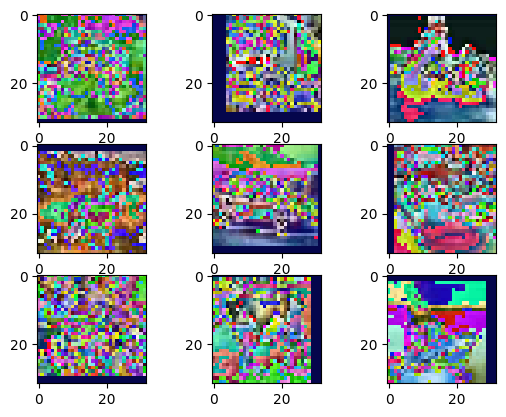

In [15]:
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()

In [19]:
training_data=CIFAR10(
    root="./data/",
    train=True,
    download=True,
    transform=ToTensor()
)

imgs=[item[0] for item in training_data]

imgs=torch.stack(imgs,dim=0).numpy()

mean_r=imgs[:,0,:,:].mean()
mean_g=imgs[:,1,:,:].mean()
mean_b=imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

std_r=imgs[:,0,:,:].std()
std_g=imgs[:,1,:,:].std()
std_b=imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


### VGG

In [25]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels,hidden_dim,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(hidden_dim,out_channels,kernel_size=3,padding=1)
        self.relu=nn.ReLU()

        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        return x
    
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN,self).__init__()

        self.block1=BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
        self.block2=BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
        self.block3=BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

        self.fc1=nn.Linear(in_features=4096, out_features=2048)
        self.fc2=nn.Linear(in_features=2048, out_features=256)
        self.fc3=nn.Linear(in_features=256, out_features=num_classes)

        self.relu=nn.ReLU()

    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=torch.flatten(x, start_dim=1)

        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)

        return x

        

In [29]:
transforms=Compose([
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),

    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261)),
])

training_data=CIFAR10(
    root="./data/",
    train=True,
    download=True,
    transform=transforms
)

test_data=CIFAR10(
    root="./data/",
    train=False,
    download=True,
    transform=transforms
)

train_loader=DataLoader(training_data, batch_size=32, shuffle=True)
test_loader=DataLoader(test_data, batch_size=32, shuffle=False)

device='cuda' if torch.cuda.is_available() else 'cpu'

model=CNN(num_classes=10)
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [34]:
lr=1e-3

optim=Adam(model.parameters(),lr=lr)

for epoch in range(1):
    for data, label in train_loader:
        optim.zero_grad()

        preds=model(data.to(device))

        loss=nn.CrossEntropyLoss()(preds,label.to(device))
        loss.backward()
        optim.step()


    if epoch==0 or epoch%10==9:
        print(f'epoch : {epoch},  loss: {loss}')

torch.save(model.state_dict(),'./model/CIFAR.pth')

epoch : 0,  loss: 0.8262128829956055


In [39]:
model.load_state_dict(torch.load("./model/CIFAR.pth", map_location=device))

num_corr=0

with torch.no_grad():
    for data, label in test_loader:

        output=model(data.to(device))
        preds=output.data.max(1)[1]
        corr=preds.eq(label.to(device).data).sum().item()
        num_corr+=corr

    print(f'Accuracy:{num_corr/len(test_data)}')

/var/folders/fm/q2x51cjs0ws3fxb93b54_dzc0000gn/T/ipykernel_7797/881785911.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model/CIFAR

Accuracy:0.709


### Transfer Learning VGG

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vgg_model=vgg16(pretrained=True)
fc=nn.Sequential(
    nn.Linear(512*7*7,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,10)
)

vgg_model.classifier=fc
vgg_model.to(device)

/Users/graceandrew/miniconda3/envs/DL/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/graceandrew/miniconda3/envs/DL/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
transforms=Compose([
    Resize(224),
    RandomCrop((224,224),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),

    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261)),
])

training_data=CIFAR10(
    root="./data/",
    train=True,
    download=True,
    transform=transforms
)

test_data=CIFAR10(
    root="./data/",
    train=False,
    download=True,
    transform=transforms
)

train_loader=DataLoader(training_data, batch_size=32, shuffle=True)
test_loader=DataLoader(test_data, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
lr=1e-4
optim=Adam(vgg_model.parameters(), lr=lr)

for epoch in range(1):
    iter=tqdm.tqdm(train_loader)
    for data, label in iter:
        optim.zero_grad()

        preds=vgg_model(data.to(device))

        loss=nn.CrossEntropyLoss()(preds,label.to(device))
        loss.backward()
        optim.step()

        iter.set_description(f'epoch: {epoch},  loss: {loss}')

torch.save(vgg_model.state_dict(),'./model/CIFAR_VGG16.pth')

In [ ]:
model.load_state_dict(torch.load('./model/CIFAR_VGG16.pth'),map_location=device)

num_corr=0

with torch.no_grad():
    for data, label in test_loader:
        
        output=model(data.to(device))
        preds=output.max(1)[1]
        corr=preds.eq(label.to(device).data).sum().item()
        num_corr+=corr

    print(f'Accuracy: {num_corr}/{len(test_data)}')

    
    